*This was my second notebook out of three. Please see my third and final notebook, [here](../notebook.ipynb), for conclusions and implications for the business.*

In this notebook, I focused on using tree-based models (decision trees, random forest and then an XGBoost classifier with standard base estimator, so also tree-based.) Use ToC to collapse EDA and skip to model selection / modeling if desired. (EDA is the same in all notebooks.)

# Health Insurance Cross Sell Prediction
Predict which of last year's health insurance customers would be interested in purchasing auto insurance to streamline the marketing and communications process.

Data source: [Kaggle](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction)

Set a seed for the random state of various functions and algorithms used in the notebook:

In [1]:
seed = 982

## Import Packages

In [3]:
# opening zipped data to load
from zipfile import ZipFile

# data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# train test split
from sklearn.model_selection import train_test_split

# preprocessing & pipelines
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# cross-validation
from sklearn.model_selection import cross_val_score, GridSearchCV

# modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.svm import SVC

# classification metrics
from sklearn.metrics import (accuracy_score, recall_score,
                             precision_score, f1_score, fbeta_score,
                             classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, plot_roc_curve,
                             roc_auc_score, roc_curve)

## Load Data

In [2]:
# what are the names of the files in the zipped archive with data
with ZipFile('data/archive.zip') as zipObject:
    print(zipObject.namelist())

['sample_submission.csv', 'test.csv', 'train.csv']


In [4]:
# load training data as pandas dataframe
with ZipFile('data/archive.zip') as zipArchive:
        with zipArchive.open('train.csv') as file:
            data = pd.read_csv(file, index_col = 0)
            
# inspect first 5 rows
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## Initial EDA

In this section, I am primarily performing exploratory data analysis *for the purpose of modeling*.

I am checking the distribution of my target, and looking for any features which appear to be strongly correlated with the target.

### Distribution of Target

In [4]:
# distribution of target
data.Response.value_counts(normalize = True)

0    0.877437
1    0.122563
Name: Response, dtype: float64

**Distribution of Target** &nbsp;&nbsp;&nbsp;&nbsp; This is an unbalanced dataset, with only about 12% of records corresponding to customers who were interested in the cross-sell.

### Correlation between Features and Target

#### Gender

In [6]:
# inspect proportion of yes / no responses by gender
print('Male:\n')
print(data.loc[data.Gender == 'Male', 'Response'].value_counts(
    normalize=True))
print('\n')
print('Female:\n')
print(data.loc[data.Gender == 'Female', 'Response'].value_counts(
    normalize=True))

Male:

0    0.861589
1    0.138411
Name: Response, dtype: float64


Female:

0    0.896098
1    0.103902
Name: Response, dtype: float64


There is not a huge difference between the percentage of men who bought vehicle insurance and the percentage of women who did so, though perhaps men are slightly more likely to purchase the insurance <mark>(- is this a statistically significant difference? use chi square test to check.)</mark>

In [7]:
print('Male:\n')
print(data.loc[data.Gender == 'Male', 'Response'].value_counts())
print('\n')
print('Female:\n')
print(data.loc[data.Gender == 'Female', 'Response'].value_counts())

Male:

0    177564
1     28525
Name: Response, dtype: int64


Female:

0    156835
1     18185
Name: Response, dtype: int64


In [10]:
from scipy import stats

gender_table = np.array([[177564, 28525], [156835, 18185]])

alpha = 0.05

stat, p, dof, expected = stats.chi2_contingency(gender_table)

if p < alpha:
    print('Strong evidence exists that conversion is contingent\
    upon gender.')
else:
    print('No evidence yet that conversion is contingent upon gender.')

Strong evidence exists that conversion is contingent    upon gender. 


#### Age

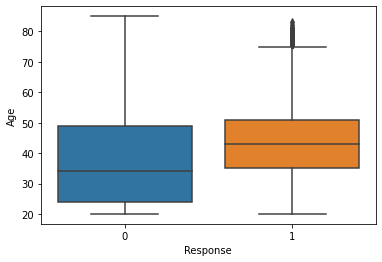

In [10]:
# inspect distribution of age by response category
sns.boxplot(data = data, x = 'Response', y = 'Age');

Perhaps our younger customers (35 and below) are not as likely to want to purchase vehicle insurance?

50% of respondents who bought vehicle insurance were between the ages of 35 and 50, and only 25% were younger than 35.

#### Driver's License

In [23]:
# did anyone without a driver's license get vehicle ins?
print('Responses for Customers without a Driver\'s License:')
data.loc[data.Driving_License==0,'Response'].value_counts(normalize=True)

Responses for Customers without a Driver's License:


0    0.949507
1    0.050493
Name: Response, dtype: float64

5% of customers who did not have a driver's license still bought vehicle insurance! But the other 95% did not.

#### Region

In [56]:
# of all vehicle insurance sales, what percentage went to each region?
by_region=data.groupby('Region_Code').sum()['Response']/sum(data.Response)

print('Percentage of Affirmative Responses by Region:')
by_region.map(lambda x: round(x, 3)).sort_values(ascending=False)

Percentage of Affirmative Responses by Region:


Region_Code
28.0    0.426
8.0     0.070
41.0    0.048
46.0    0.044
29.0    0.029
3.0     0.025
11.0    0.022
15.0    0.021
30.0    0.019
35.0    0.019
33.0    0.016
18.0    0.015
36.0    0.015
47.0    0.014
50.0    0.014
45.0    0.013
39.0    0.012
48.0    0.010
7.0     0.009
14.0    0.009
6.0     0.009
37.0    0.009
38.0    0.008
13.0    0.008
24.0    0.007
12.0    0.007
4.0     0.006
10.0    0.006
2.0     0.006
23.0    0.006
21.0    0.006
19.0    0.005
32.0    0.005
20.0    0.005
43.0    0.005
9.0     0.005
26.0    0.004
0.0     0.004
17.0    0.004
27.0    0.004
31.0    0.004
16.0    0.003
34.0    0.003
40.0    0.003
5.0     0.003
49.0    0.003
22.0    0.002
25.0    0.002
1.0     0.002
51.0    0.001
42.0    0.001
44.0    0.001
52.0    0.001
Name: Response, dtype: float64

Region 28 had 42% of all vehicle insurance sales in this dataset. Is this a particularly large region? Is there some other reason that such a high percentage of sales would happen here?

In [41]:
# is region 28 just big?
len(data.loc[ data.Region_Code == 28, 'Response' ])

106415

Region 28 has 106,415 customers associated with it in this dataset. I need a way to compare this with other regions.

In [46]:
data.groupby('Region_Code').count()['Response'].\
sort_values(ascending=False)

Region_Code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
23.0      1960
31.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: Response, dtype: int64

Region 28 is just big, not necessarily getting a higher percentage of vehicle insurance sales. This suggests that my initial way of analyzing the data is flawed.

Let's try to find, instead, the percentage of vehicle insurance sales by region out of all customers in that region.

In [52]:
# divide the number of 1s by the total number of records PER REGION

region_percentage = data.loc[ data.Response == 1 ].groupby('Region_Code')\
.count()['Response'] / data.groupby('Region_Code').count()['Response']

# sort in descending order

region_percentage.sort_values(ascending = False)

Region_Code
38.0    0.192004
28.0    0.187163
19.0    0.162866
4.0     0.158245
23.0    0.153061
51.0    0.153005
24.0    0.141615
7.0     0.131747
18.0    0.131574
3.0     0.127662
35.0    0.124604
39.0    0.123600
52.0    0.123596
29.0    0.123362
41.0    0.121776
40.0    0.118147
5.0     0.115715
20.0    0.115245
11.0    0.112760
45.0    0.109723
1.0     0.108135
46.0    0.102891
48.0    0.101901
31.0    0.100510
33.0    0.099294
12.0    0.097561
8.0     0.096142
43.0    0.092459
14.0    0.090209
13.0    0.090188
47.0    0.087682
0.0     0.086096
32.0    0.085755
9.0     0.081587
36.0    0.079914
37.0    0.079258
34.0    0.075721
49.0    0.074782
42.0    0.074450
27.0    0.074035
30.0    0.073825
26.0    0.072284
15.0    0.071987
2.0     0.071075
21.0    0.071027
17.0    0.070310
6.0     0.069904
16.0    0.066766
22.0    0.063407
50.0    0.062677
10.0    0.060128
25.0    0.042749
44.0    0.040842
Name: Response, dtype: float64

Ok, so some regions have a higher conversion rate for vehicle insurance, others don't. This could be a valuable feature in a predictive model, but it might simply be correlated with something else that is affecting sales (for example, policy sales channel - a certain agent or agents may be GREAT at selling, and works within a particular region, boosting the conversion rate for the region. But that doesn't mean that more customers in that region want to buy vehicle insurance, necessarily. So it's not really the region that is making the sale. I wonder if a decision tree or random forest would help parse out the true cause?)

#### Previously Insured

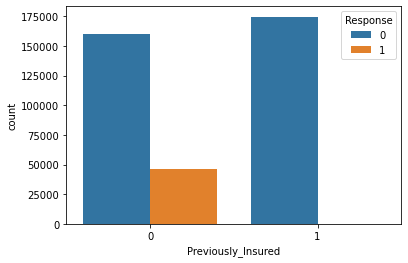

In [26]:
# how does already having vehicle insurance affect response rate?
sns.countplot(data = data, x = 'Previously_Insured', hue = 'Response');

In [27]:
# virtually no one who already has vehicle ins went for the cross-sell
data.loc[ data['Previously_Insured'] == 1 , 'Response'].value_counts()

0    174470
1       158
Name: Response, dtype: int64

So 158 people who already had vehicle insurance *did* purchase vehicle insurance from us as well, but this is a miniscule percentage compared to the percentage of people who didn't already have vehicle insurance who bought it from us.

**Below**
<mark> In revisiting the visualizations below for vehicle damage and vehicle age, I think what we really need are numbers to support any conclusions from these visualizations. E.g., I need to know what percentage of customers with vehicle damage opted in for vehicle insurance, and I need to know the percentage of customers without damage who opted in. Knowing the raw numbers exactly could be helpful, too.</mark>

#### Vehicle Damage

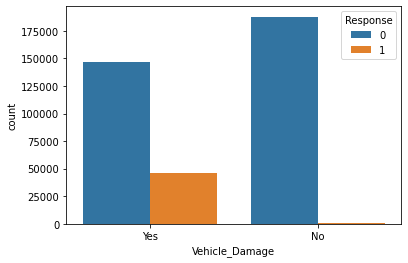

In [30]:
# how does vehicle damage (or lack thereof) affect response rate?
sns.countplot(data = data, x = 'Vehicle_Damage', hue = 'Response');

A higher percentage of people who have sustained vehicle damage agreed to purchase vehicle insurance. <mark>*This is an ambiguous statement. Re-word.*</mark>

#### Vehicle Age

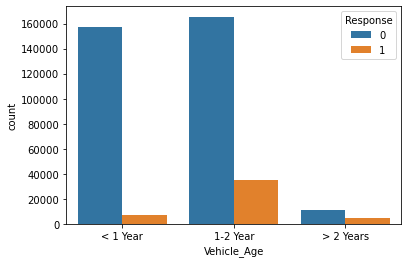

In [32]:
# Is there a correlation b/w vehicle age & response rate?
sns.countplot(data = data, x = 'Vehicle_Age', hue = 'Response',
             order = ['< 1 Year', '1-2 Year', '> 2 Years']);
# it was confusing me a little when the x-axis wasn't "in order" by length
# of time, hence the argument above to the order parameter

In terms of percentages, the probability is highest that someone with a vehicle more than 2 years old will opt in to vehicle insurance. But in terms of raw numbers, customers with cars between 1 and 2 years of age are buying the most vehicle insurance. <mark>All of these statements are coming out ambiguous. I will need to clarify my thinking and rewrite these viz summaries.</mark>

#### Vintage

So this deserves some explanation. 'Vintage' refers to *how many days the customer has been with the company*. It has nothing to do with whether or not their car is vintage. 😀

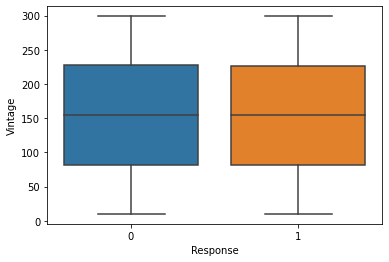

In [36]:
# distribution of vintage by response category
sns.boxplot(data = data, x = 'Response', y = 'Vintage');

Interestingly, the distribution of vintage ("customer age with the company", if you will,) is pretty much the same for those who did and didn't purchase vehicle insurance. So brand trust / loyalty doesn't seem to play a role here. (Or if it does, it is not clear from the data.)

#### Annual Premium

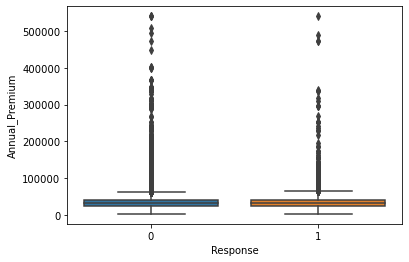

In [33]:
# distribution of annual premiums by response category
sns.boxplot(data = data, x = 'Response', y = 'Annual_Premium');

The amount of the annual premium doesn't seem to matter very much in terms of predicting which of our customers will purchase vehicle insurance.

#### Policy Sales Channel

In [4]:
# what percentage of sales for each policy sales channel?
by_channel=data.groupby('Policy_Sales_Channel').sum()['Response']\
/ sum(data.Response)

print('Percentage of Vehicle Insurance Purchases by Policy Sales Channel:')
by_channel.map(lambda x: round(x, 3)).sort_values(ascending=False)

Percentage of Vehicle Insurance Purchases by Policy Sales Channel:


Policy_Sales_Channel
26.0     0.340
124.0    0.300
152.0    0.083
156.0    0.049
157.0    0.038
         ...  
84.0     0.000
86.0     0.000
87.0     0.000
88.0     0.000
81.0     0.000
Name: Response, Length: 155, dtype: float64

Two policy sales channels outweigh the rest, resulting in more than 60% of the vehicle insurance sales overall.

This feature refers to the method of contacting the customer (i.e. by mail, by various agents, etc.) The initial analysis seems to reveal that some methods are more effective than others in closing the sale.

## Model Selection

### Feature Selection

While technically, feature selection is a separate process from model selection, they are inexplicably intertwined because the type of data you are using to train your model affects the best model to use in that situation.

There are relatively few features, and some of them are cumbersome to include in a model (e.g. `Region_Code` would need to be one hot encoded with a minimum of 49 categories), so I am going to select some features to include by hand.

**Included Features**

- Age
- Driving_License
- Previously_Insured
- Vehicle_Damage
- Vehicle_Age (one hot encode)

#### Feature Engineering

I would love to include `Policy_Sales_Channel` because it seems so important, but there are 155 unique policy sales channels that would need to be one hot encoded! I am going to try including just the top 5 policy sales channels.

In [4]:
# feature engineering: a feature per channel for the top 5 policy channs

# obtain a series which gives the percentage of all vehicle sales in the
# dataset that were sold through a particular policy sales channel.
# I am going to consider that this is not data leakage because this
# feature itself is not going to be included in the model.

all_channels = data.groupby('Policy_Sales_Channel').sum()['Response']\
/ sum(data.Response)

# sort the series above by its values, to determine the top 5 policy
# sales channels as determined by percentage of all vehicle insurance
# sales that were attributed to that channel in this dataset.

top_5_channels = all_channels.sort_values(ascending=False).index[:5]

# view the top_5_channels and the percentage of vehicle ins sales made
# through them
all_channels[top_5_channels]

Policy_Sales_Channel
26.0     0.340206
124.0    0.299636
152.0    0.082595
156.0    0.049176
157.0    0.038407
Name: Response, dtype: float64

Viewing the top 5 policy sales channels, I realize that I should probably only include the top *two* policy sales channels.

In [5]:
# get top 2 channels instead
top_2_channels = all_channels.sort_values(ascending=False).index[:2]

# add feature to dataset
for channel_code in top_2_channels:
    data[f'channel{int(channel_code)}'] = (data.Policy_Sales_Channel ==
                                           channel_code).astype(int)
    
# check work
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,channel26,channel124
id,,,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,1,0
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,1,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,1,0
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,0,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,0,0


When I tried to pass this data to a Decision Tree Classifier, I learned that the symbols "<" and ">" are not allowed in strings. The below code replaces those values.

In [6]:
# create a dict mapping old values in Vehicle_Age col to new values
new_values = dict(zip(data['Vehicle_Age'].value_counts().index,
                      ['1-2YR', 'under_1YR', 'over_2YR']))

# pass that dict to the replace function applied to Vehicle_Age col
data.Vehicle_Age.replace(new_values, inplace = True)

#### Potential Improvement (to feature selection process)

Start with all (feasible) features and prune features by feature importance, one by one, to see if it makes a difference in model performance. *This would entail adding: Gender, Vintage and Annual Premium, which are currently not included. Vintage and Annual Premium are continuous; Gender is categorical and just needs to be converted to numerical type.*

### Train Test Split

To aid in selecting the best model, we are going to split our training data into training and test sets. The test data in a separate file within our data folder can then be used as a validation set for our final model.

In [7]:
# separate data into feature set and target
X = data.drop(['Gender', 'Region_Code', 'Vintage', 'Annual_Premium',
              'Policy_Sales_Channel', 'Response'], axis = 1)
y = data['Response']

# inspect first few rows for any issues
X.head()

,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,channel26,channel124
id,,,,,,,
1,44,1,0,over_2YR,Yes,1,0
2,76,1,0,1-2YR,No,1,0
3,47,1,0,over_2YR,Yes,1,0
4,21,1,1,under_1YR,No,0,0
5,29,1,1,under_1YR,No,0,0


In [9]:
y.head()

id
1    1
2    0
3    1
4    0
5    0
Name: Response, dtype: int64

Now we will use SciKit Learn's train_test_split function to separate our data into a training and test set.

In [8]:
# actually perform train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = seed)

# check work
pd.concat([X_train, y_train], axis = 1).head()

,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,channel26,channel124,Response
id,,,,,,,,
374459,54,1,0,1-2YR,Yes,0,0,0
342742,45,1,0,over_2YR,Yes,0,0,1
190270,22,1,1,under_1YR,No,0,0,0
339967,60,1,1,1-2YR,No,0,0,0
75048,25,1,0,under_1YR,Yes,0,0,0


### Preprocessing

Check for missing values and check data types for modeling.

In [11]:
X_train.isna().sum()

Age                   0
Driving_License       0
Previously_Insured    0
Vehicle_Age           0
Vehicle_Damage        0
channel26             0
channel124            0
dtype: int64

In [12]:
X_train.dtypes

Age                    int64
Driving_License        int64
Previously_Insured     int64
Vehicle_Age           object
Vehicle_Damage        object
channel26              int64
channel124             int64
dtype: object

In [9]:
# make the vehicle_damage column 0 / 1 instead of Yes / No

X_train.Vehicle_Damage.replace({'Yes':1, 'No':0}, inplace = True)
X_test.Vehicle_Damage.replace({'Yes':1, 'No':0}, inplace = True)


# instantiate one hot encoder
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

# fit encoder & transform vehicle age; keep index & add column names
transformed_cat_col = pd.DataFrame(
    ohe.fit_transform(X_train[['Vehicle_Age']]),
    columns = ohe.categories_[0],
    index = X_train.Vehicle_Age.index)

# concatenate transformed vehicle age with other features in X_train
X_train = pd.concat([X_train.drop(['Vehicle_Age'], axis = 1),
                     transformed_cat_col], axis = 1)

# now transform X_test without fitting
transformed_cat_col_test = pd.DataFrame(
    ohe.transform(X_test[['Vehicle_Age']]),
    columns = ohe.categories_[0],
    index = X_test.Vehicle_Age.index)

# concatenate transformed vehicle age with other features in X_test
X_test = pd.concat([X_test.drop(['Vehicle_Age'], axis = 1),
                    transformed_cat_col_test], axis = 1)

# check work
X_train.head()

/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Age,Driving_License,Previously_Insured,Vehicle_Damage,channel26,channel124,1-2YR,over_2YR,under_1YR
id,,,,,,,,,
374459,54,1,0,1,0,0,1.0,0.0,0.0
342742,45,1,0,1,0,0,0.0,1.0,0.0
190270,22,1,1,0,0,0,0.0,0.0,1.0
339967,60,1,1,0,0,0,1.0,0.0,0.0
75048,25,1,0,1,0,0,0.0,0.0,1.0


In [14]:
X_test.head()

,Age,Driving_License,Previously_Insured,Vehicle_Damage,channel26,channel124,1-2YR,over_2YR,under_1YR
id,,,,,,,,,
331220,25,1,1,0,0,0,0.0,0.0,1.0
147239,22,1,1,0,0,0,0.0,0.0,1.0
173112,42,1,0,1,0,0,1.0,0.0,0.0
150201,27,1,0,1,0,0,0.0,0.0,1.0
105933,25,1,1,0,0,0,0.0,0.0,1.0


### Custom Function: Print Metrics

So that I don't have to type this many times later, let's go ahead and build a function that takes in a model and a training and testing set, and prints the classification report for the model on each set. (We can modify this function later to focus on a specific metric, like f1 score or precision, or to output additional information, like an ROC curve or confusion matrix.)

In [10]:
# model metric printer
def get_metrics(model, X_train, y_train, X_test, y_test):
    # fit the model to the training data
    model.fit(X_train, y_train)
    
    # make predictions on training and test sets
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    
    # print classification report for each
    print('Metrics on Training Set:')
    print(classification_report(y_train, y_train_preds))
    print('Metrics on Test Set:')
    print(classification_report(y_test, y_test_preds))

## BL Decision Tree

Because most of the features I chose to include are really categorical, I want to start the modeling process with a nonparametric model (decision tree) rather than a linear model like logistic regression.

In [16]:
# instantiate a decision tree classifier
dt = DecisionTreeClassifier(random_state = seed)

# examine metrics
get_metrics(dt, X_train, y_train, X_test, y_test)

Metrics on Training Set:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    250865
           1       0.55      0.01      0.03     34966

    accuracy                           0.88    285831
   macro avg       0.71      0.51      0.48    285831
weighted avg       0.84      0.88      0.82    285831

Metrics on Test Set:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     83534
           1       0.50      0.01      0.03     11744

    accuracy                           0.88     95278
   macro avg       0.69      0.51      0.48     95278
weighted avg       0.83      0.88      0.82     95278



Our baseline model has a precision of 55% and a recall of only 1% on the training data, and a precision of 50% and a recall of only 1% on the test data.

I am not concerned about accuracy because of the class imbalance in the dataset - an algorithm which selects the majority class every time will have an average accuracy of 87% or 88% which is similar to that of this model, but it will be useless in terms of generating leads for the sales team.

To combat this, let's apply under and oversampling to the dataset, and retrain our baseline decision tree model on that data.

## Under & Over Sampling

In [17]:
# instantiate random under sampler and synthetic over sampler
rus = RandomUnderSampler(sampling_strategy = 0.5, # 1 to 2 min:maj ratio
                         random_state = seed)
sos = SMOTE(random_state = seed) # add synth. minority samples to equalize

# note: can come back and play with sampling_strategy of rus & number of
# neighbors to consider when forming synth samples in sos

# create a pipeline to undersample, then oversample
sampling_pipe = Pipeline(steps = [
    ('undersample', rus),
    ('oversample', sos)
]
                        )

# apply sampling pipeline to training data
X_train_resampled, y_train_resampled = sampling_pipe.fit_resample(X_train,
                                                                  y_train)

In [18]:
X_train_resampled.head()

,Age,Driving_License,Previously_Insured,Vehicle_Damage,channel26,channel124,1-2YR,over_2YR,under_1YR
0,22,1,0,0,0,0,0.0,0.0,1.0
1,66,1,0,1,0,0,1.0,0.0,0.0
2,23,1,0,0,0,0,0.0,0.0,1.0
3,52,1,0,1,1,0,1.0,0.0,0.0
4,25,1,1,0,0,0,0.0,0.0,1.0


Note that indices are different after synthetic over sampling. (Of course.) This shouldn't be a problem, but it's something to be aware of as we code.

## Decision Tree, Resampled Data

In [19]:
# no need to reinstatiate the earlier baseline decision tree; just change
# the data being passed in as the training set

# examine metrics
get_metrics(dt, X_train_resampled, y_train_resampled, X_test, y_test)

Metrics on Training Set:
              precision    recall  f1-score   support

           0       0.91      0.66      0.76     69932
           1       0.73      0.93      0.82     69932

    accuracy                           0.80    139864
   macro avg       0.82      0.80      0.79    139864
weighted avg       0.82      0.80      0.79    139864

Metrics on Test Set:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79     83534
           1       0.28      0.93      0.42     11744

    accuracy                           0.69     95278
   macro avg       0.63      0.79      0.61     95278
weighted avg       0.90      0.69      0.74     95278



On the training data (resampled), our model now has a recall of 93% and a precision of 73%.

These metrics, while they could theoretically be improved, would possibly be quite livable for the sales team if these were the metrics on the test set; a long run conversion rate of 73% (when only 12% of existing health insurance customers are interested in purchasing vehicle insurance) and capturing 93% of the "market" for vehicle insurance (within the pool of existing health insurance customers) is pretty good.

On the testing data, however, the metrics are much more grim. The precision of the model falls to 28%, though our recall remains at 93%.

Accuracy also decreases on the test set, suggesting that our model is overfit, but it is important to keep in mind that we are not optimizing for accuracy, so we want to proceed in a way that considers the best way to improve precision without letting recall fall too much.

Using the f1 score for now as a proxy of the balance between precision and recall would be appropriate. We could also try using an f-beta score if we want to optimize for one more than the other.

Before we try to improve our tree or move on to an ensemble model, let's take a look at our current tree.

In [61]:
# tree stats
print(f'Depth of tree: {dt.tree_.max_depth}')
print(f'Node count: {dt.tree_.node_count}')

Depth of tree: 20
Node count: 1783


No wonder our tree is overfit! That's a lot of nodes.

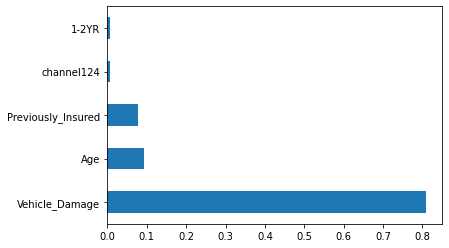

In [63]:
# feature importances
feat_importances = pd.Series(dt.feature_importances_,
                             index=X_train_resampled.columns)
feat_importances.nlargest(5).plot(kind='barh');

Vehicle damage is much more important than all of the other features to the splits being made in this decision tree. Perhaps building a random forest will help the model correct itself on records for which vehicle damage is misleading.

## BL Random Forest

To hopefully improve the precision of our model, let's try building a random forest of decision trees instead of one overfit decision tree.

Note - I don't think it's worth building any additional models on the original, totally imbalanced training data, so I am going to keep using the resampled training data for now. It might be beneficial to try other approaches to resampling later to try to improve our best model results further.

In [20]:
# instantiate baseline random forest classifier
rf = RandomForestClassifier(random_state = seed)

# get metrics for the model on our resampled training data & test data
get_metrics(rf, X_train_resampled, y_train_resampled, X_test, y_test)

Metrics on Training Set:
              precision    recall  f1-score   support

           0       0.91      0.66      0.76     69932
           1       0.73      0.94      0.82     69932

    accuracy                           0.80    139864
   macro avg       0.82      0.80      0.79    139864
weighted avg       0.82      0.80      0.79    139864

Metrics on Test Set:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79     83534
           1       0.28      0.93      0.42     11744

    accuracy                           0.69     95278
   macro avg       0.63      0.79      0.61     95278
weighted avg       0.90      0.69      0.74     95278



There was **no change** in any of the metrics going from a single decision tree to a random forest. This is suprising and suggests to me two things:

1. So far, resampling the training data has produced the biggest change in our metrics (radically increasing recall, but severely reducing precision on the test set.) Trying different methods for dealing with the imbalance in classes may be the best way to produce a model with markedly different metrics (hopefully, for the better.)



2. Our model is still overfitting, so we can try tuning hyperparameters that are designed to reduce overfitting. (For example, setting the max_depth of the decision trees in our forest to a smaller number.)

In [71]:
# first, inspect trees in current forest

# get the max_depth for each tree stored in estimators list of
# random forest
tree_depths = [rf.estimators_[i].tree_.max_depth for i in
               range(len(rf.estimators_))]

# print mean and standard deviation of tree depths
print(f'Mean Tree Depth: {int(np.mean(tree_depths))}')
print(f'Standard Deviation: {int(np.std(tree_depths))}')

Mean Tree Depth: 20
Standard Deviation: 1


All of our trees have pretty much the same depth as our initial decision tree.

In theory, our trees are allowed to be overfit, and the fact that they are *overfit in different ways* will allow the overall forest to make a surprisingly accurate prediction due to variance in different directions canceling each other out. However, this is not happening, so let's try forcing each one of our trees to focus on fewer features (especially since we have so few features in the dataset anyway.)

## Model Selection

### print fbeta function

First, let's define a function to get the $F\beta$ score for a model, to help us balance the tradeoff between precision and recall with a slight bias towards recall ($\beta > 1$.)

In [80]:
# get f beta score for a model on training and test set
def get_fbeta(model, X_train, y_train, X_test, y_test):
    # fit the model to the training data
    model.fit(X_train, y_train)
    
    # make predictions on training and test sets
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    
    # print classification report for each
    print('F Beta Score on Training Set, B = 1.2:')
    print(fbeta_score(y_train, y_train_preds, beta = 1.2))
    print('F Beta Score on Test Set, B = 1.2:')
    print(fbeta_score(y_test, y_test_preds, beta = 1.2))

### Tune max_depth

Because we used SMOTE to oversample our training data, it is inadvisable to use cross validation to determine the best model (since this would be using synthetic samples in the test set.)

Therefore, I am going to skip grid search cv and write my own code to test out the effect of different values for max_depth on the fbeta score of my random forest on the test set.

In [83]:
# max_depths to try
max_depths = [1, 5, 9, 15] # original has no limit, so no need for > 20

for max_depth in max_depths:
    # instantiate a random forest with the given max_depth
    rf_md_tuned = RandomForestClassifier(max_depth = max_depth,
                                         random_state = seed)
    
    # get & print the f beta score for each model
    get_fbeta(rf_md_tuned,
                X_train_resampled,
                y_train_resampled,
                X_test,
                y_test)
    
    # print some vertical space to separate results visually
    print('\n\n')

F Beta Score on Training Set, B = 1.2:
0.843856941691073
F Beta Score on Test Set, B = 1.2:
0.4479614400198715



F Beta Score on Training Set, B = 1.2:
0.8307875267429214
F Beta Score on Test Set, B = 1.2:
0.47570894525644936



F Beta Score on Training Set, B = 1.2:
0.8439858474924729
F Beta Score on Test Set, B = 1.2:
0.46575841872382456



F Beta Score on Training Set, B = 1.2:
0.8396264891094712
F Beta Score on Test Set, B = 1.2:
0.4705367004328845





The random forest with `max_depth` = 5 had the best $F\beta$ score on the test set, but unfortunately, it's still not a very good score.

### Adjust Sampling Strategy

I am going to try other ways of dealing with the class imbalance since that has had the biggest effect on model performance so far.

One thing we can try is changing the ratio of the minority to the majority class in the random under sampler we use before applying SMOTE.

In [84]:
# make a list of sampling strategies to try for the random under sampler
sampling_strategies = np.linspace(0.2, 1, 9)

for sampling_strategy in sampling_strategies:

    # instantiate random under sampler and synthetic over sampler
    rus = RandomUnderSampler(sampling_strategy = sampling_strategy,
                             random_state = seed)
    sos = SMOTE(random_state = seed)

    # create a pipeline to undersample, then oversample
    sampling_pipe = Pipeline(steps = [
        ('undersample', rus),
        ('oversample', sos)
    ]
                        )

    # apply sampling pipeline to training data
    X_train_re_resampled, y_train_re_resampled = sampling_pipe.\
    fit_resample(X_train, y_train)
    
    # get f beta score for baseline random forest with new training data
    get_fbeta(rf,
              X_train_re_resampled,
              y_train_re_resampled,
              X_test,
              y_test)
    
    # print a couple of spaces between metrics
    print('\n\n')

F Beta Score on Training Set, B = 1.2:
0.8352731221192915
F Beta Score on Test Set, B = 1.2:
0.4745350081356755



F Beta Score on Training Set, B = 1.2:
0.8397570991351169
F Beta Score on Test Set, B = 1.2:
0.4704935675425707



F Beta Score on Training Set, B = 1.2:
0.8423038621225742
F Beta Score on Test Set, B = 1.2:
0.4670814624224776



F Beta Score on Training Set, B = 1.2:
0.839318371369443
F Beta Score on Test Set, B = 1.2:
0.4704573412775697



F Beta Score on Training Set, B = 1.2:
0.8372021654189389
F Beta Score on Test Set, B = 1.2:
0.4716493720021845



F Beta Score on Training Set, B = 1.2:
0.8425527528909414
F Beta Score on Test Set, B = 1.2:
0.46605264269719887



F Beta Score on Training Set, B = 1.2:
0.8385231733725563
F Beta Score on Test Set, B = 1.2:
0.47001187417201185



F Beta Score on Training Set, B = 1.2:
0.8383212998238693
F Beta Score on Test Set, B = 1.2:
0.4698547100509345



F Beta Score on Training Set, B = 1.2:
0.8414141274811371
F Beta Score on Test 

Changing the random undersampling strategy didn't change much.

### Tune max_samples & class_weight

Let's try using the *entire* training set, and just using balanced class weights on each subsample selected by the random forest. In fact, I'm also going to tune the `max_samples` parameter to try selecting smaller subsets of the overall dataset to try to work out the imbalance naturally. With grid search, we can try different combinations of class weight strategy and number of samples drawn.

In [99]:
# create a parameter grid
param_grid = [
    {'max_samples': [0.05, 0.10, 0.30, 0.50], # try smaller samples, and
     # balance using distribution of sample, or not at all
     'class_weight': ['balanced_subsample', None]},
    # try smaller sample or whole data set, and balance by distribution of
    # whole data set or individual samples
    {'max_samples': [0.12, 0.5, 1],
     'class_weight': ['balanced', 'balanced_subsample']}
]

# this is going to build 8 + 6, so 14 models

# create a grid search cv object
# use f1 score to order results
search = GridSearchCV(rf, param_grid, scoring = 'f1')

# fit to ALL training data
search.fit(X_train, y_train)

# view best estimator and score
print(f'Best estimator: {search.best_estimator_}')
print(f'Best f1 score: {search.best_score_}')

Best estimator: RandomForestClassifier(class_weight='balanced_subsample', max_samples=0.05,
                       random_state=982)
Best f1 score: 0.4298244521427047


The best F1 score is still terrible!

Is this the best I can do on this dataset for now?

### Undersample Only

One last thing that occurs to me is to try adjusting the sampling strategy gradually and seeing if we can pinpoint a better balance between precision and recall.

Sampling the training data so that we had an equal number of records for positive and negative classes reduced the precision and increased the recall dramatically.

What if we try undersampling so that the (natural) class weights are gradually less and less imbalanced, looking at the F1 scores, recall and precision scores along the way?

In the original dataset, the ratio of the minority class to the majority class is somewhere between 0.1 and 0.2. So let's try random under sampling with ratios of minority to majority between 0.2 and 1.

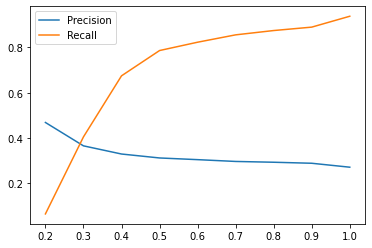

In [114]:
# try different ratios of minority to majority class with under-sampling
# start with 2:10, try up to 1:1
sampling_strategies = np.linspace(0.2, 1, 9)

# plot precision and recall vs. sampling_strategy
precisions = []
recalls = []

# iterate over sampling strategies
for sampling_strategy in sampling_strategies:
    
    # instantiate a random under sampler with current sampling strategy
    rus_only = RandomUnderSampler(sampling_strategy = sampling_strategy,
                                  random_state = seed)
    
    # fit undersampler to training data, and resample training data
    X_train_undersampled, y_train_undersampled = rus_only.fit_resample(
        X_train,
        y_train
    )
    
    # fit random forest to undersampled training data
    rf.fit(X_train_undersampled, y_train_undersampled)
    
    # make predictions on test set
    y_test_preds = rf.predict(X_test)
    
    # record precision and recall for this model
    precisions.append(precision_score(y_test, y_test_preds))
    recalls.append(recall_score(y_test, y_test_preds))

# plot precision and recall vs sampling strategy
fig, ax = plt.subplots()

sns.lineplot(x = sampling_strategies, y = precisions, label = 'Precision')
sns.lineplot(x = sampling_strategies, y = recalls, label = 'Recall')
ax.legend();

So the furthest points to the *left* are pretty close to where we started: low recall, about 50% precision.

Recall climbs more quickly than precision falls, but unfortunately, precision starts pretty low.

## XGBoost Classifier

My results with a random forest classifier have not been good enough to generate useful leads for the company. Let's try a boosted version of random forest, XGBoost Classifier, and see if it can get better results.

I'm trying XGBoost because it has done so well on so many different kinds of classification problems, so hopefully, it will do well on this one.

In [140]:
# use undersample of original training data with 1:1 minority/major ratio
rus = RandomUnderSampler(random_state = seed)
X_under, y_under = rus.fit_resample(X_train, y_train)
print(f'No. of observations in training data: {X_under.shape[0]}\n')

# instantiate a baseline XGBoost Classifier
xgb = XGBClassifier(random_state = seed)

# get metrics for baseline XGBClassifier on undersampled training data
get_metrics(xgb,
            X_under,
            y_under,
            X_test,
            y_test)

No. of observations in training data: 69932

Metrics on Training Set:
              precision    recall  f1-score   support

           0       0.92      0.64      0.76     34966
           1       0.73      0.95      0.82     34966

    accuracy                           0.79     69932
   macro avg       0.82      0.79      0.79     69932
weighted avg       0.82      0.79      0.79     69932

Metrics on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.64      0.78     83534
           1       0.27      0.94      0.42     11744

    accuracy                           0.68     95278
   macro avg       0.63      0.79      0.60     95278
weighted avg       0.90      0.68      0.74     95278



Adjust sampling_strategy (of the random under sampler), just in case it makes a difference.

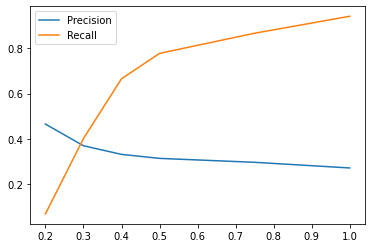

In [141]:
# record precision & recall with each sampling_strategy
precisions = []
recalls = []

for sampling_strategy in [0.2, 0.3, 0.4, 0.5, 0.75, 1]:
    # use undersample of original training data with 1:1 minority:major
    rus = RandomUnderSampler(sampling_strategy = sampling_strategy,
                             random_state = seed)
    X_under, y_under = rus.fit_resample(X_train, y_train)

    # fit xgb to data
    xgb.fit(X_under, y_under)
    
    # predict on test set & get precision & recall
    y_test_preds = xgb.predict(X_test)
    precisions.append(precision_score(y_test, y_test_preds))
    recalls.append(recall_score(y_test, y_test_preds))
    
# plot precision & recall w.r.t. sampling strategy min: max ratio
fig, ax = plt.subplots()

# precision as a function of sampling strategy
sns.lineplot(x = [0.2, 0.3, 0.4, 0.5, 0.75, 1], y = precisions,
             label = 'Precision')

# recall as a function of sampling strategy
sns.lineplot(x = [0.2, 0.3, 0.4, 0.5, 0.75, 1], y = recalls,
             label = 'Recall')
ax.legend();

## Conclusion

We may just not have the right data to generate precise predictions for which of our health insurance customers is interested in purchasing vehicle insurance with the company.

Our best model had a precision of less than 30% on the test set, and a recall a little above 90%.

To translate this into business terms, using only this model to generate leads, the sales team would have an average conversion rate of 30% (in the long run, perhaps for the month or for the quarter) and, if they had time to contact *every* lead suggested by the model, they would capture about 90% of the market for vehicle insurance among our health insurance customers.

## Next Steps

- Dashboard, to view...
    - vehicle insurance sales data by region
    - vehicle insurance sales data by policy sales channel
    - leads, ranked by probability (using logistic regression)
    - sales, inverse-weighted by size, by region
- Collect more data that might help improve the model

## Appendix: Trying Logistic Regression

In [13]:
# undersample only
rus = RandomUnderSampler(random_state = seed)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
X_train_resampled.head()

,Age,Driving_License,Previously_Insured,Vehicle_Damage,channel26,channel124,1-2YR,over_2YR,under_1YR
0,22,1,0,0,0,0,0.0,0.0,1.0
1,66,1,0,1,0,0,1.0,0.0,0.0
2,23,1,0,0,0,0,0.0,0.0,1.0
3,52,1,0,1,1,0,1.0,0.0,0.0
4,25,1,1,0,0,0,0.0,0.0,1.0


In [16]:
# scale data appropriately
ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_resampled),
                              index = X_train_resampled.index,
                              columns = X_train_resampled.columns)
X_test_scaled = pd.DataFrame(ss.transform(X_test),
                             index = X_test.index,
                             columns = X_test.columns)

X_train_scaled.head()

,Age,Driving_License,Previously_Insured,Vehicle_Damage,channel26,channel124,1-2YR,over_2YR,under_1YR
0,-1.311360,0.039511,-0.595738,-1.561242,-0.601534,-0.56317,-1.277339,-0.267595,1.480911
1,1.757724,0.039511,-0.595738,0.640516,-0.601534,-0.56317,0.782878,-0.267595,-0.675260
2,-1.241608,0.039511,-0.595738,-1.561242,-0.601534,-0.56317,-1.277339,-0.267595,1.480911
3,0.781197,0.039511,-0.595738,0.640516,1.662417,-0.56317,0.782878,-0.267595,-0.675260
4,-1.102104,0.039511,1.678590,-1.561242,-0.601534,-0.56317,-1.277339,-0.267595,1.480911


In [20]:
# instantiate vanilla logistic regression
logreg = LogisticRegression(random_state=seed, C=0.2)

# check metrics
get_metrics(logreg,
            X_train_scaled,
            y_train_resampled,
            X_test_scaled,
            y_test)

Metrics on Training Set:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     34966
           1       0.70      0.97      0.82     34966

    accuracy                           0.78     69932
   macro avg       0.83      0.78      0.77     69932
weighted avg       0.83      0.78      0.77     69932

Metrics on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     83534
           1       0.25      0.97      0.40     11744

    accuracy                           0.64     95278
   macro avg       0.62      0.78      0.57     95278
weighted avg       0.90      0.64      0.70     95278



In [21]:
# don't undersample; use all training data
# scale data appropriately
ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train),
                              index = X_train.index,
                              columns = X_train.columns)
X_test_scaled = pd.DataFrame(ss.transform(X_test),
                             index = X_test.index,
                             columns = X_test.columns)

X_train_scaled.head()

,Age,Driving_License,Previously_Insured,Vehicle_Damage,channel26,channel124,1-2YR,over_2YR,under_1YR
id,,,,,,,,,
374459,0.978868,0.046056,-0.919621,0.989742,-0.515175,-0.490968,0.949278,-0.208919,-0.872414
342742,0.398326,0.046056,-0.919621,0.989742,-0.515175,-0.490968,-1.053432,4.786534,-0.872414
190270,-1.085281,0.046056,1.087405,-1.010364,-0.515175,-0.490968,-1.053432,-0.208919,1.146245
339967,1.365896,0.046056,1.087405,-1.010364,-0.515175,-0.490968,0.949278,-0.208919,-0.872414
75048,-0.891767,0.046056,-0.919621,0.989742,-0.515175,-0.490968,-1.053432,-0.208919,1.146245


In [22]:
# instantiate vanilla logistic regression
logreg = LogisticRegression(random_state=seed)

# check metrics
get_metrics(logreg,
            X_train_scaled,
            y_train,
            X_test_scaled,
            y_test)

Metrics on Training Set:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    250865
           1       0.33      0.00      0.00     34966

    accuracy                           0.88    285831
   macro avg       0.61      0.50      0.47    285831
weighted avg       0.81      0.88      0.82    285831

Metrics on Test Set:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     83534
           1       0.00      0.00      0.00     11744

    accuracy                           0.88     95278
   macro avg       0.44      0.50      0.47     95278
weighted avg       0.77      0.88      0.82     95278



In [33]:
# try tweaking logistic regression hyperparameters
logreg = LogisticRegression(random_state=seed,
                            C = 0.3)

# check metrics
get_metrics(logreg,
            X_train_scaled,
            y_train,
            X_test_scaled,
            y_test)

Metrics on Training Set:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    250865
           1       0.33      0.00      0.00     34966

    accuracy                           0.88    285831
   macro avg       0.61      0.50      0.47    285831
weighted avg       0.81      0.88      0.82    285831

Metrics on Test Set:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     83534
           1       0.00      0.00      0.00     11744

    accuracy                           0.88     95278
   macro avg       0.44      0.50      0.47     95278
weighted avg       0.77      0.88      0.82     95278



In [41]:
# try smote only
smote = SMOTE(random_state = seed,
              sampling_strategy = 0.4)
X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)
X_train_smoted.head()

,Age,Driving_License,Previously_Insured,Vehicle_Damage,channel26,channel124,1-2YR,over_2YR,under_1YR
0,54,1,0,1,0,0,1.0,0.0,0.0
1,45,1,0,1,0,0,0.0,1.0,0.0
2,22,1,1,0,0,0,0.0,0.0,1.0
3,60,1,1,0,0,0,1.0,0.0,0.0
4,25,1,0,1,0,0,0.0,0.0,1.0


In [42]:
# now scale
ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_smoted),
                              index = X_train_smoted.index,
                              columns = X_train_smoted.columns)
X_test_scaled = pd.DataFrame(ss.transform(X_test),
                             index = X_test.index,
                             columns = X_test.columns)

X_train_scaled.head()

,Age,Driving_License,Previously_Insured,Vehicle_Damage,channel26,channel124,1-2YR,over_2YR,under_1YR
0,0.950983,0.044077,-0.771489,0.827705,-0.553033,-0.522527,0.872563,-0.234746,-0.782972
1,0.352811,0.044077,-0.771489,0.827705,-0.553033,-0.522527,-1.146165,4.260924,-0.782972
2,-1.175848,0.044077,1.296195,-1.208160,-0.553033,-0.522527,-1.146165,-0.234746,1.277383
3,1.349763,0.044077,1.296195,-1.208160,-0.553033,-0.522527,0.872563,-0.234746,-0.782972
4,-0.976458,0.044077,-0.771489,0.827705,-0.553033,-0.522527,-1.146165,-0.234746,1.277383


In [43]:
# instantiate logreg
logreg = LogisticRegression(random_state = seed)

# check metrics
get_metrics(logreg,
            X_train_scaled,
            y_train_smoted,
            X_test_scaled,
            y_test)

Metrics on Training Set:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83    250865
           1       0.58      0.62      0.60    100346

    accuracy                           0.76    351211
   macro avg       0.71      0.72      0.71    351211
weighted avg       0.77      0.76      0.76    351211

Metrics on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     83534
           1       0.32      0.62      0.42     11744

    accuracy                           0.79     95278
   macro avg       0.63      0.72      0.65     95278
weighted avg       0.86      0.79      0.82     95278



In [44]:
# iterate over sampling strategies
sampling_strategies = [0.2, 0.3, 0.4, 0.5]

for i, sampling_strategy in enumerate(sampling_strategies):
    # smote training data
    smote = SMOTE(random_state = seed,
                  sampling_strategy = sampling_strategy)
    X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)

    # scale data
    ss = StandardScaler()
    X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_smoted),
                                  index = X_train_smoted.index,
                                  columns = X_train_smoted.columns)
    X_test_scaled = pd.DataFrame(ss.transform(X_test),
                                 index = X_test.index,
                                 columns = X_test.columns)

    # instantiate logreg
    logreg = LogisticRegression(random_state = seed)

    # check metrics
    get_metrics(logreg,
                X_train_scaled,
                y_train_smoted,
                X_test_scaled,
                y_test)
    print('\n\n')

Metrics on Training Set:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91    250865
           1       0.34      0.01      0.02     50173

    accuracy                           0.83    301038
   macro avg       0.59      0.50      0.46    301038
weighted avg       0.75      0.83      0.76    301038

Metrics on Test Set:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     83534
           1       0.30      0.01      0.02     11744

    accuracy                           0.87     95278
   macro avg       0.59      0.50      0.48     95278
weighted avg       0.81      0.87      0.82     95278




Metrics on Training Set:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87    250865
           1       0.54      0.32      0.40     75259

    accuracy                           0.78    326124
   macro avg       0.68      0.62      0.63    326124


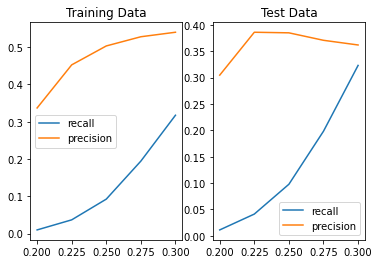

In [47]:
# iterate over sampling strategies
sampling_strategies = np.linspace(0.2, 0.3, 5)

# store training, test recall and precision
train_r = []
train_p = []
test_r = []
test_p = []

for i, sampling_strategy in enumerate(sampling_strategies):
    # smote training data
    smote = SMOTE(random_state = seed,
                  sampling_strategy = sampling_strategy)
    X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)

    # scale data
    ss = StandardScaler()
    X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_smoted),
                                  index = X_train_smoted.index,
                                  columns = X_train_smoted.columns)
    X_test_scaled = pd.DataFrame(ss.transform(X_test),
                                 index = X_test.index,
                                 columns = X_test.columns)

    # instantiate & fit logreg
    logreg = LogisticRegression(random_state = seed)
    logreg.fit(X_train_scaled, y_train_smoted)
    
    # append training, test precision and recall
    train_r.append(recall_score(y_train_smoted,
                                logreg.predict(X_train_scaled)))
    train_p.append(precision_score(y_train_smoted,
                                logreg.predict(X_train_scaled)))
    test_r.append(recall_score(y_test,
                               logreg.predict(X_test_scaled)))
    test_p.append(precision_score(y_test,
                                  logreg.predict(X_test_scaled)))
    
# print precision & recall versus sampling strategy

fig, ax = plt.subplots(ncols = 2)

ax[0].set_title('Training Data')
sns.lineplot(x=sampling_strategies, y=train_r, label='recall', ax=ax[0])
sns.lineplot(x=sampling_strategies, y=train_p, label='precision',
             ax=ax[0])

ax[1].set_title('Test Data')
sns.lineplot(x=sampling_strategies, y=test_r, label='recall', ax=ax[1])
sns.lineplot(x=sampling_strategies, y=test_p, label='precision',
             ax=ax[1]);

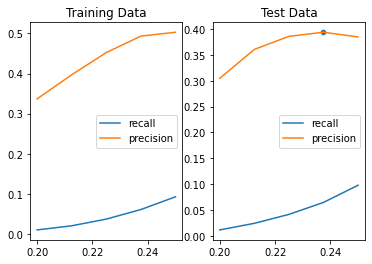

In [51]:
# iterate over sampling strategies
sampling_strategies = np.linspace(0.2, 0.25, 5)

# store training, test recall and precision
train_r = []
train_p = []
test_r = []
test_p = []

for i, sampling_strategy in enumerate(sampling_strategies):
    # smote training data
    smote = SMOTE(random_state = seed,
                  sampling_strategy = sampling_strategy)
    X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)

    # scale data
    ss = StandardScaler()
    X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_smoted),
                                  index = X_train_smoted.index,
                                  columns = X_train_smoted.columns)
    X_test_scaled = pd.DataFrame(ss.transform(X_test),
                                 index = X_test.index,
                                 columns = X_test.columns)

    # instantiate & fit logreg
    logreg = LogisticRegression(random_state = seed)
    logreg.fit(X_train_scaled, y_train_smoted)
    
    # append training, test precision and recall
    train_r.append(recall_score(y_train_smoted,
                                logreg.predict(X_train_scaled)))
    train_p.append(precision_score(y_train_smoted,
                                logreg.predict(X_train_scaled)))
    test_r.append(recall_score(y_test,
                               logreg.predict(X_test_scaled)))
    test_p.append(precision_score(y_test,
                                  logreg.predict(X_test_scaled)))
    
# print precision & recall versus sampling strategy

fig, ax = plt.subplots(ncols = 2)

ax[0].set_title('Training Data')
sns.lineplot(x=sampling_strategies, y=train_r, label='recall', ax=ax[0])
sns.lineplot(x=sampling_strategies, y=train_p, label='precision',
             ax=ax[0])

ax[1].set_title('Test Data')
sns.lineplot(x=sampling_strategies, y=test_r, label='recall', ax=ax[1])
sns.lineplot(x=sampling_strategies, y=test_p, label='precision',
             ax=ax[1])
sns.scatterplot(x=[0.2375], y = test_p[3], marker='o');

Best precision on test data: sampling strategy for SMOTE is 0.2375.

In [52]:
test_p[3]

0.3939551849921834

The best precision is still low (39%.)